# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [21]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [22]:
# visualizing the data

print(df.shape)
print("===")
print(df)
print("===")
print(df.pop("Y1"))

(768, 10)
===
       X1     X2     X3     X4   X5  X6    X7  X8     Y1     Y2
0    0.82  612.5  318.5  147.0  7.0   4  0.25   4  25.43  28.76
1    0.66  759.5  318.5  220.5  3.5   2  0.25   3  12.97  15.53
2    0.62  808.5  367.5  220.5  3.5   2  0.40   4  16.44  17.10
3    0.74  686.0  245.0  220.5  3.5   2  0.10   4  10.08  13.20
4    0.76  661.5  416.5  122.5  7.0   3  0.40   5  39.72  39.80
..    ...    ...    ...    ...  ...  ..   ...  ..    ...    ...
763  0.74  686.0  245.0  220.5  3.5   5  0.25   5  12.02  14.03
764  0.79  637.0  343.0  147.0  7.0   4  0.40   5  41.09  47.01
765  0.86  588.0  294.0  147.0  7.0   4  0.25   4  29.08  33.93
766  0.90  563.5  318.5  122.5  7.0   4  0.10   3  29.62  30.08
767  0.74  686.0  245.0  220.5  3.5   4  0.25   5  11.64  14.81

[768 rows x 10 columns]
===
0      25.43
1      12.97
2      16.44
3      10.08
4      39.72
       ...  
763    12.02
764    41.09
765    29.08
766    29.62
767    11.64
Name: Y1, Length: 768, dtype: float64


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [23]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

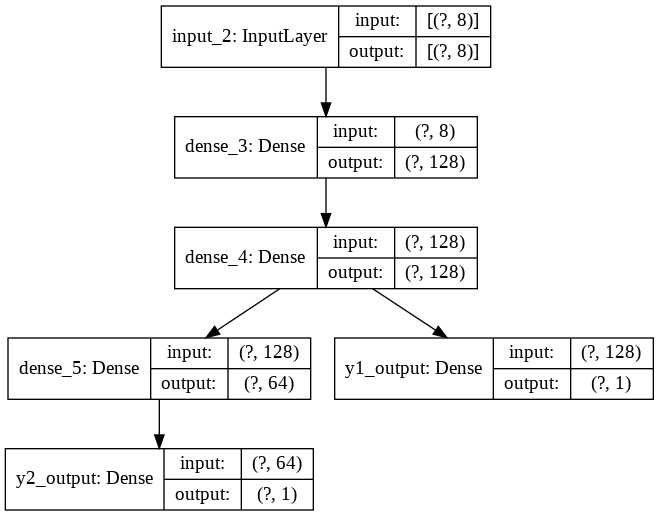

In [24]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [25]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [26]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 0s 804us/sample - loss: 269.5398 - y1_output_loss: 126.4239 - y2_output_loss: 140.5432 - y1_output_root_mean_squared_error: 11.2985 - y2_output_root_mean_squared_error: 11.9115 - val_loss: 33.2833 - val_y1_output_loss: 15.0367 - val_y2_output_loss: 17.1767 - val_y1_output_root_mean_squared_error: 3.9387 - val_y2_output_root_mean_squared_error: 4.2154
Epoch 2/500
614/614 [==============================] - 0s 129us/sample - loss: 29.8102 - y1_output_loss: 11.9737 - y2_output_loss: 17.9167 - y1_output_root_mean_squared_error: 3.4642 - y2_output_root_mean_squared_error: 4.2201 - val_loss: 74.6814 - val_y1_output_loss: 17.8254 - val_y2_output_loss: 54.6602 - val_y1_output_root_mean_squared_error: 4.2999 - val_y2_output_root_mean_squared_error: 7.4962
Epoch 3/500
614/614 [==============================] - 0s 139us/sample - loss: 24.7391 - y1_output_loss: 10.0525 - y2_output_loss: 14.6250 - y1

## Evaluate the Model and Plot Metrics

In [27]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 36us/sample - loss: 0.9424 - y1_output_loss: 0.4030 - y2_output_loss: 0.5334 - y1_output_root_mean_squared_error: 0.6377 - y2_output_root_mean_squared_error: 0.7319
Loss = 0.9423702738501809, Y1_loss = 0.40303176641464233, Y1_mse = 0.637680172920227, Y2_loss = 0.5334492325782776, Y2_mse = 0.7319387197494507


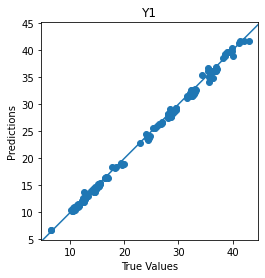

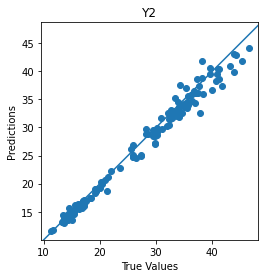

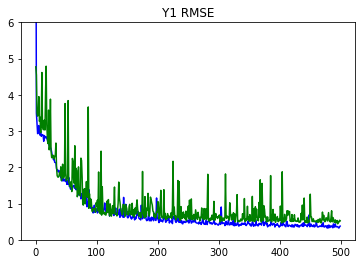

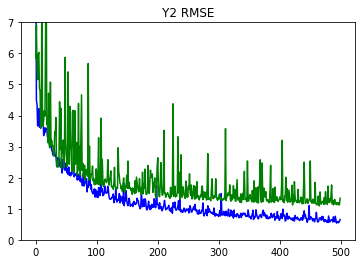

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)